# MNIST convolutional neural networks

* Make a networks like LeNet5 structure with MNIST data
* input pipeline: `tf.data`
* `Eager execution`

## Import modules

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras import layers
tf.enable_eager_execution()

os.environ["CUDA_VISIBLE_DEVICES"]="0"

/home/multi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Import data

In [2]:
# Load training and eval data from tf.keras
(train_data, train_labels), (test_data, test_labels) = \
    tf.keras.datasets.mnist.load_data()

train_data = train_data / 255.
train_data = train_data.reshape([-1, 28, 28, 1])
train_data = train_data.astype(np.float32)
train_labels = train_labels.astype(np.int32)

test_data = test_data / 255.
test_data = test_data.reshape([-1, 28, 28, 1])
test_data = test_data.astype(np.float32)
test_labels = test_labels.astype(np.int32)

### Show the MNIST

label = 5


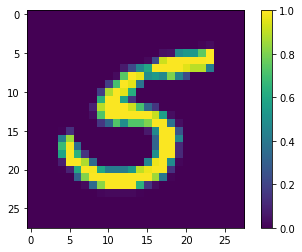

In [3]:
index = 219
print("label = {}".format(train_labels[index]))
plt.imshow(train_data[index][...,0])
plt.colorbar()
#plt.gca().grid(False)
plt.show()

## Set up dataset with `tf.data`

### input pipeline `tf.data.Dataset` and Transformation

In [ ]:
tf.set_random_seed(219)
batch_size = 32
max_epochs = 1

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset = train_dataset.shuffle(buffer_size = 10000)
train_dataset = train_dataset.batch(batch_size = batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
test_dataset = test_dataset.batch(batch_size = batch_size)
print(test_dataset)

## Create the model

* Use `tf.keras.layers`

In [ ]:
model = tf.keras.Sequential([
  layers.Conv2D(filters=32, kernel_size=[5, 5],
                padding='same', activation='relu'),
  layers.MaxPool2D(),
  layers.Conv2D(filters=64, kernel_size=[5, 5],
                padding='same', activation='relu'),
  layers.MaxPool2D(),
  layers.Flatten(),
  layers.Dense(1024, activation='relu'),
  layers.Dense(10)])

In [ ]:
# without training, just inference a model in eager execution:
for images, labels in train_dataset.take(1):
  print("Logits: ", model(images[0:3]).shape)

In [ ]:
model.summary()

## Train a model

### Define a optimizer

In [ ]:
optimizer = tf.train.AdamOptimizer(1e-4)
loss_history = []

### Train a model

In [ ]:
global_step = tf.train.get_or_create_global_step()
for epoch in range(max_epochs):
  for images, labels in train_dataset:
    start_time = time.time()
    with tf.GradientTape() as tape:
      logits = model(images, training=True)
      loss_value = tf.losses.sparse_softmax_cross_entropy(labels, logits)

    loss_history.append(loss_value.numpy())
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables),
                              global_step=global_step)

    if global_step.numpy() % 100 == 0:
      clear_output(wait=True)
      duration = time.time() - start_time
      examples_per_sec = batch_size / float(duration)
      epochs = batch_size * global_step.numpy() / float(len(train_data))
      print("epochs: {:.2f}, step: {}, loss: {:g}, ({:.2f} examples/sec; {:.3f} sec/batch)".format(epochs, global_step.numpy(), loss_value, examples_per_sec, duration))

print("training done!")

### Plot the loss funtion

In [ ]:
plt.plot(loss_history, label='loss')
plt.xlabel('Number of steps')
plt.ylabel('Loss value [cross entropy]')
plt.legend()
plt.show()

## Evaluate a model

### Test trained model

* test accuracy: 0.9798 for 1 epochs

In [ ]:
accuracy = tf.contrib.eager.metrics.Accuracy()

for images, labels in test_dataset:
  logits = model(images, training=False)
  accuracy(labels=labels, predictions=tf.cast(tf.argmax(logits, 1), tf.int32))
  
print("test accuracy: {}".format(accuracy.result()))

### Plot test set

In [ ]:
np.random.seed(219)

In [ ]:
test_batch_size = 16
batch_index = np.random.choice(len(test_data), size=test_batch_size, replace=False)

batch_xs = test_data[batch_index]
batch_ys = test_labels[batch_index]
y_pred_ = model(batch_xs, training=False)

fig = plt.figure(figsize=(16, 10))
for i, (px, py) in enumerate(zip(batch_xs, y_pred_)):
  p = fig.add_subplot(4, 8, i+1)
  if np.argmax(py) == batch_ys[i]:
    p.set_title("y_pred: {}".format(np.argmax(py)), color='blue')
  else:
    p.set_title("y_pred: {}".format(np.argmax(py)), color='red')
  p.imshow(px.reshape(28, 28))
  p.axis('off')